In [1]:
import numpy as np
import numpy.linalg as la
from reach import Reach
import os
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing

In [2]:
#pathnames
relpron_path = './RELPRON/RELPRON/translation_basic.txt'
verbs_path = './verbmatrices/version3'
vectorspath = './tulkens-embeddings/160/sonar-160.txt'
resultspath = './compare-phrases-results.txt'
figpath = './figures'
tablepath = './avona-data.txt'

In [3]:
#import data
relpron_file = open(relpron_path,'r', encoding='latin-1')
items_raw = relpron_file.readlines()
relpron_file.close()

r = Reach(vectorspath, header=True)

verbmatrices = dict()
for verbfile in os.listdir(verbs_path):
    verbmatrices[verbfile[:-4]] = np.load(verbs_path+'/'+verbfile)


Vocab: 626711, Dim: 160


In [4]:
class Sentence:
    def __init__(self, string):
        key, self.propertystr = string[:-1].split(': ')
        self.relation, self.termN = key.split(' ')
        self.rel = self.relation[0]
        propertylst = self.propertystr.split(' ')
        self.headN = propertylst[0]
        self.argN = propertylst[2]
        v_inflected, v_root = propertylst[-1].split('/')
        self.V = v_root
        
items = dict()
for item in items_raw:
    sent = Sentence(item)
    if sent.termN not in items:
        items[sent.termN] = [sent]
    else:
        items[sent.termN].append(sent)

In [5]:
variance_control = True
mean_std = 0.08

class PhraseComposer:
    def __init__(self, sentence):
        """Load vectors and matrices for the phrase"""
        self.relation = sentence.rel
        self.arg_v = r.vector(sentence.argN)
        self.arg_v = self.Scale(self.arg_v)
        self.head_v = r.vector(sentence.headN)
        self.head_v = self.Scale(self.head_v)
        
        self.V_v = r.vector(sentence.V)
        self.VO_m = verbmatrices[sentence.V+'|O']
        self.VS_m = verbmatrices[sentence.V+'|S']
        
    def Scale(self, v):
        """Apply standard scaling to argument vector as was done in training."""
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.set_params(with_std=variance_control)
        v = scaler.fit_transform(v[:, np.newaxis])
        v = np.squeeze(v)
        if variance_control:
            v = mean_std * v
        return v
        
    
    def Compose(self, method):
        """Direct to proper composition method based on input string"""
        if method == 'vector addition':
            return self.VectorAddition()
        if method == 'PLF':
            return self.FullMatrix()
        if method == 'V-arg matrix':
            return self.VArgMatrix()
        if method == 'V-head matrix':
            return self.VHeadMatrix()
        if method == 'iPLF':
            return self.FullMatrixWrongStructure()
        
    def VectorAddition(self):
        return np.add(self.head_v, self.arg_v, self.V_v)

    def VHeadMatrix(self, relation=None):
        if not relation:
            relation = self.relation
        if relation == 'O':
            return np.dot(self.head_v, self.VO_m)
        else:
            return np.dot(self.head_v, self.VS_m)
    
    def VArgMatrix(self, relation=None):
        if not relation:
            relation = self.relation
        if relation == 'O':
            return np.dot(self.arg_v, self.VS_m)
        else:
            return np.dot(self.arg_v, self.VO_m)
    
    def FullMatrix(self):
        return np.add(self.VArgMatrix(), self.VHeadMatrix())
    
    def FullMatrixWrongStructure(self):
        if self.relation == 'O':
            relation = 'S'
        else:
            relation = 'O'
        return(np.add(self.VArgMatrix(relation), self.VHeadMatrix(relation)))

## Correlations between sentences: initial testing

In [6]:
# try out some functions

vectors_addition = list()
vectors_matrix = list()
indices = list()

for term in list(items.keys()):
    for sent in items[term]:
        if sent.V+'|O' in verbmatrices and sent.V+'|S' in verbmatrices:
            indices.append(sent)
            composer = PhraseComposer(sent)

            composed_matrix = composer.Compose('PLF')
            composed_addition = composer.Compose('vector addition')

            vectors_addition.append(composed_addition)
            vectors_matrix.append(composed_matrix)

In [7]:
# print a matrix to check results manually

corr_m = np.corrcoef(np.vstack(vectors_matrix))
#corr_m = np.corrcoef(np.vstack(composed_matrix))

tags = [sent.termN for sent in indices]

df = pd.DataFrame(corr_m, index=tags, columns=tags)

print(df)

           garnizoen  garnizoen  garnizoen    missie    missie    missie  \
garnizoen   1.000000   0.780948   0.755619  0.925604  0.689331  0.744331   
garnizoen   0.780948   1.000000   0.850621  0.737035  0.723581  0.699789   
garnizoen   0.755619   0.850621   1.000000  0.736707  0.670333  0.661065   
missie      0.925604   0.737035   0.736707  1.000000  0.715241  0.711985   
missie      0.689331   0.723581   0.670333  0.715241  1.000000  0.691283   
missie      0.744331   0.699789   0.661065  0.711985  0.691283  1.000000   
missie      0.920226   0.740272   0.729635  0.995992  0.727454  0.703883   
missie      0.780829   0.775539   0.724810  0.770986  0.921925  0.770669   
missie      0.785736   0.749629   0.754338  0.724509  0.668386  0.761044   
missie      0.911262   0.742659   0.743927  0.975943  0.713029  0.704970   
familie     0.726926   0.753417   0.704146  0.723850  0.670276  0.732397   
familie     0.668795   0.580603   0.671725  0.649704  0.607177  0.560485   
familie     

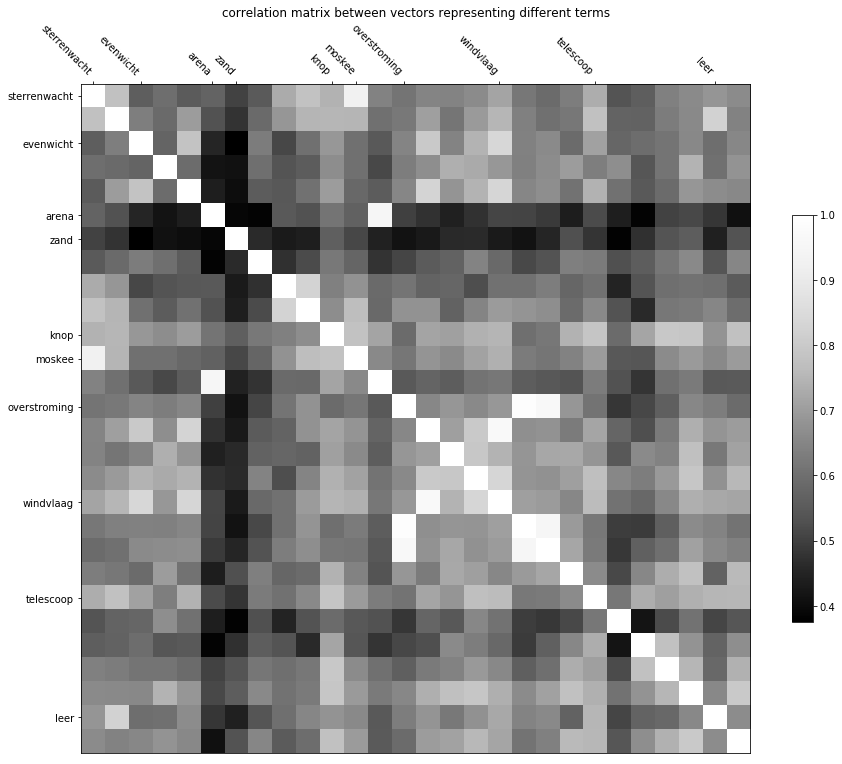

In [10]:
# show a colored matrix of correlations between each sentence pair. Keep in mind that for the graph to be readable,
# you need to restrict the number of terms you are calculating above.

indices = []
ticks = []
lastindex = ''
for i in range(len(df.index)):
    if lastindex != df.index[i]:
        indices.append(df.index[i])
        lastindex = df.index[i]
        ticks.append(i)


fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(df.values, cmap="Greys_r")

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(indices)
ax.set_yticklabels(indices)
ax.xaxis.tick_top()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right")

#add legend
fig.colorbar(im, shrink=0.5)

ax.set_title("correlation matrix between vectors representing different terms")
plt.show()

## Correlations between sentences: same term vs different terms

In [37]:
#  for histogram below: make a st of correlations with the same and different terms.

corrs_sameterm = []
corrs_diffterms = []

for i in range(len(tags)):
    for j in range(len(tags)):
        if i != j:
            term_i = tags[i]
            term_j = tags[j]
            corr = df.values[i,j]
            if term_i == term_j:
                corrs_sameterm.append(corr)
            else:
                corrs_diffterms.append(corr)

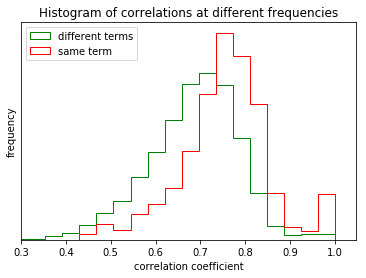

In [38]:
# plot histogram

plt.hist([corrs_sameterm, corrs_diffterms], bins=25, histtype='step', color=['r','g'], density=True)
plt.yticks([])
plt.xlabel('correlation coefficient')
plt.ylabel('frequency')
plt.xlim(left=0.3)
plt.title('Histogram of correlations at different frequencies')
plt.legend(['different terms', 'same term'], loc='upper left')

In [39]:
# print median of correlations.

sameterm_median = np.median(corrs_sameterm)
diffterms_median = np.median(corrs_diffterms)
print(sameterm_median)
print(diffterms_median)

0.7592632916059401
0.6937330217132653


## Compare methods

In [8]:
#proper loop through all methods

datadict = dict()
methods = ['vector addition', 'PLF', 'iPLF', 'V-arg matrix', 'V-head matrix']

for method in methods:
    vectors = list()
    indices = list()

    for term in list(items.keys()):
        for sent in items[term]:
            if sent.V+'|O' in verbmatrices and sent.V+'|S' in verbmatrices:
                indices.append(sent)
                composer = PhraseComposer(sent)
                vectors.append(composer.Compose(method))
    datadict[method] = {'vectors': vectors, 'indices': indices}

results = dict()
    
for method in methods:
    corr_m = np.corrcoef(np.vstack(datadict[method]['vectors']))

    corrs_sameterm = []
    corrs_diffterms = []
    
    tags = [sent.termN for sent in datadict[method]['indices']]

    for i in range(len(tags)):
        for j in range(len(tags)):
            if i != j:
                term_i = tags[i]
                term_j = tags[j]
                corr = corr_m[i,j]
                if term_i == term_j:
                    corrs_sameterm.append(corr)
                else:
                    corrs_diffterms.append(corr)
    
    results[method] = {'same M': np.mean(corrs_sameterm), 'diff M': np.mean(corrs_diffterms)}
    results[method]['same SD'] = np.std(corrs_sameterm)
    results[method]['diff SD'] = np.std(corrs_diffterms)
    t, p = stats.ttest_ind(corrs_sameterm, corrs_diffterms, equal_var=False)
    results[method]['t'] = t
    results[method]['p'] = p
    
for method in sorted(results.keys()):
    for result in sorted(results[method].keys()):
        if result == 'p':
            p = results[method][result]
            if p < 0.001:
                print(method, 'p-value\t', '<0.001', sep='\t')
            else:
                print(method, 'p-value\t', p, sep='\t')
        else:
            print(method, result, results[method][result], sep='\t')

PLF	diff M	0.6842342520513477
PLF	diff SD	0.10074592164359326
PLF	p-value		<0.001
PLF	same M	0.7519194303774281
PLF	same SD	0.09851266467042531
PLF	t	25.839402386993445
V-arg matrix	diff M	0.6043835846584201
V-arg matrix	diff SD	0.1214160570250575
V-arg matrix	p-value		<0.001
V-arg matrix	same M	0.6729944391471254
V-arg matrix	same SD	0.122722587605383
V-arg matrix	t	21.031610564598225
V-head matrix	diff M	0.6534725317262033
V-head matrix	diff SD	0.1042763596794362
V-head matrix	p-value		<0.001
V-head matrix	same M	0.7339693732543392
V-head matrix	same SD	0.1068854067174946
V-head matrix	t	28.33442345557469
iPLF	diff M	0.6860894751238394
iPLF	diff SD	0.09547174175591158
iPLF	p-value		<0.001
iPLF	same M	0.7489625426699853
iPLF	same SD	0.09740505913865632
iPLF	t	24.28402539362128
vector addition	diff M	0.5445708682847695
vector addition	diff SD	0.15243473832583562
vector addition	p-value		<0.001
vector addition	same M	0.6159226505998721
vector addition	same SD	0.1829825431074516
vector a

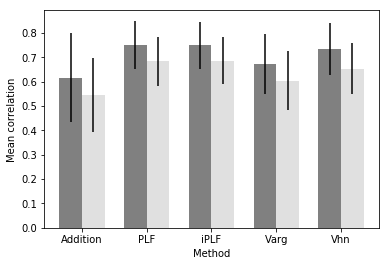

In [9]:
# make bar chart of data above.


N = len(methods)
sameMeans = [results[method]['same M'] for method in methods]
sameStd = [results[method]['same SD'] for method in methods]

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, sameMeans, width, color='grey', bottom=0, yerr=sameStd)



diffMeans = [results[method]['diff M'] for method in methods]
diffStd = [results[method]['diff SD'] for method in methods]

p2 = ax.bar(ind + width, diffMeans, width,
            color='#e0e0e0', bottom=0, yerr=diffStd)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Addition', 'PLF', 'iPLF', 'Varg', 'Vhn'])

plt.xlabel('Method')
plt.ylabel('Mean correlation')

#plt.figlegend((p1[0], p2[0]), ('Same term', 'Different terms'), loc='lower center')
ax.autoscale_view()

plt.show()



In [11]:
#save results to file
outfile = open(resultspath, 'w')
for method in sorted(results.keys()):
    for result in sorted(results[method].keys()):
        if result == 'p':
            p = results[method][result]
            if p < 0.0001:
                outfile.write(method+'\tp-value\t<0.0001')
            else:
                outfile.write(method+'\tp-value\t'+str(p))
            outfile.write('\n')
        else:
            outfile.write(method+'\t'+result+'\t'+str(results[method][result]))
            outfile.write('\n')
outfile.close()

In [10]:
# export data to perform a mixed anova


#construct dataframe

col_index = []
col_type = []
datacols = dict()

tags = [sent.termN for sent in indices]

corr_ms = {}

for method in methods:
    corr_ms[method] = np.corrcoef(np.vstack(datadict[method]['vectors']))
    datacols[method] = []

for i in range(len(tags)):
    for j in range(len(tags)):
        if i != j:
            col_index.append(str(i)+'_'+str(j))
            if tags[i] == tags[j]:
                col_type.append('1')
            else:
                col_type.append('0')
            for method in methods:
                datacols[method].append(corr_ms[method][i,j])
        

values = np.array([col_type]+[datacols[method] for method in methods]).T

table = pd.DataFrame(data=values, index=col_index, columns=['Terms']+methods, dtype=float)

In [16]:
#export to txt file
outfile = open(tablepath, 'w')

outfile.write('#\t')
outfile.write('\t'.join(table.columns))
outfile.write('\n')

for i in range(len(table.index)):
    index = table.index[i]
    row = table.iloc[i]
    outfile.write(index)
    for x in row:
        if x == 1 or x == 0:
            outfile.write('\t'+str(int(x)))
        else:
            outfile.write('\t'+str(round(x,3)))
    outfile.write('\n')

outfile.close()

## Correlation between PLF and iPLF results

In [11]:
# get data

#get vectors

data = {'O': list(), 'S': list(), 'PLF': list(), 'iPLF': list()}

for sent in indices:
    composer = PhraseComposer(sent)
    if sent.relation == 'OBJ':
        data['O'].append(composer.head_v)
        data['S'].append(composer.arg_v)
    if sent.relation == 'SBJ':
        data['S'].append(composer.head_v)
        data['O'].append(composer.arg_v)        
    data['PLF'].append(composer.Compose('PLF'))
    data['iPLF'].append(composer.Compose('iPLF'))
    
#compute correlations

cors_so = list()
cors_comp = list()

for i in range(len(data['O'])):
    cor_so = stats.pearsonr(data['O'][i], data['S'][i])
    cors_so.append(cor_so[0])
    cor_comp = stats.pearsonr(data['PLF'][i], data['iPLF'][i])
    cors_comp.append(cor_comp[0])

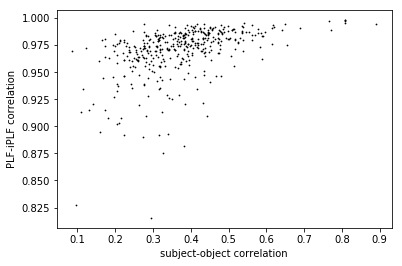

In [12]:
plt.plot(cors_so, cors_comp, 'k.', markersize=1.5)
plt.xlabel('subject-object correlation')
plt.ylabel('PLF-iPLF correlation')

plt.savefig(figpath+'/PLF_iPLF_correlation.svg', transparent=True)